In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Data preprocessing

In [3]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### class imbalance

In [5]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



### clean, split, and normalize data

In [6]:
cleaned_df = raw_df.copy()

# remove time column
cleaned_df.pop('Time')

# amount column has a huge range, convert to log-space
eps = 0.001
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

In [7]:
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# get labels and features
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [8]:
# normalize data
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features) # only fit on the training set
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


### data distribution

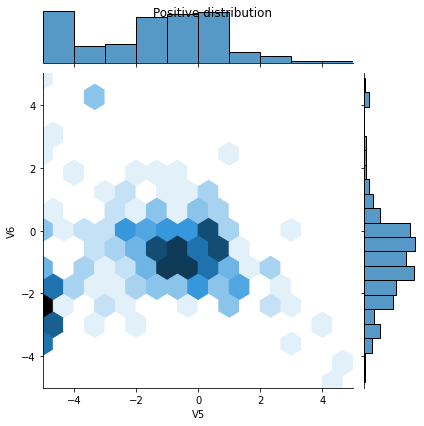

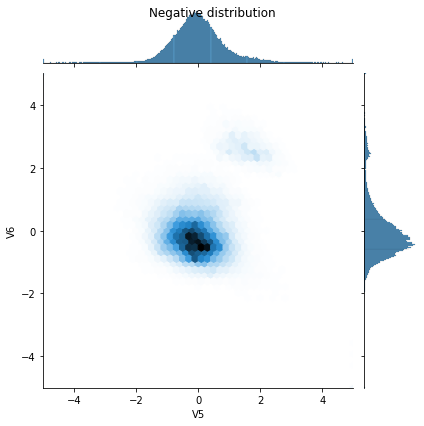

In [9]:
pos_df = pd.DataFrame(train_features[bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

# Build model

In [10]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1], )),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
    ])

    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss=keras.losses.BinaryCrossentropy(), metrics=metrics)

    return model

In [11]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

In [12]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


### init bias

In [13]:
# test model
model.predict(train_features[:10])

array([[0.7715573 ],
       [0.761946  ],
       [0.98036855],
       [0.8396506 ],
       [0.47267774],
       [0.6898396 ],
       [0.7234466 ],
       [0.89619744],
       [0.45849591],
       [0.6795365 ]], dtype=float32)

In [14]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.3202


In [15]:
# set a better initial bias
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [16]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00064665],
       [0.000574  ],
       [0.00014688],
       [0.00061721],
       [0.00162104],
       [0.00489034],
       [0.00328855],
       [0.00127122],
       [0.00310322],
       [0.00059023]], dtype=float32)

In [17]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0139


In [18]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [19]:
# model with naive bias
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=20, validation_data=(val_features, val_labels), verbose=0)

In [20]:
# model with better init bias
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=20, validation_data=(val_features, val_labels), verbose=0)

In [21]:
def plot_loss(history, label, n):
    plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch, history.history['val_loss'], color=colors[n], label='Val '+label, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

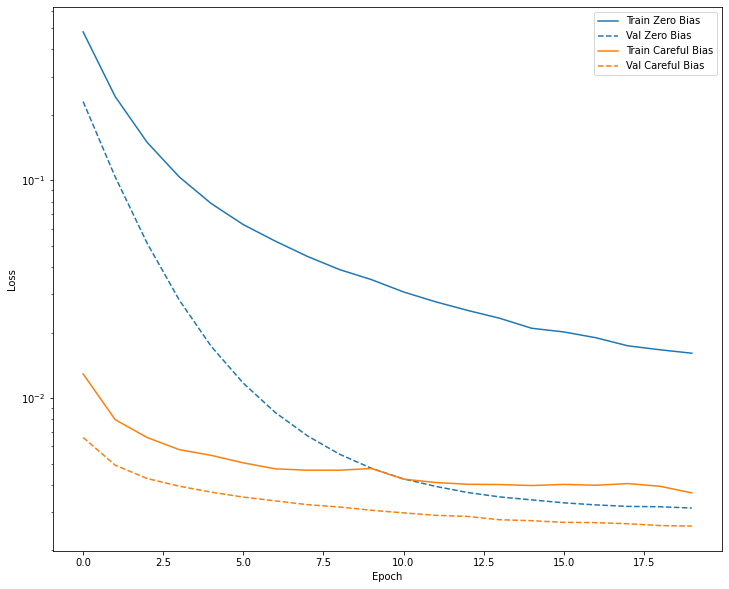

In [22]:
plot_loss(zero_bias_history, 'Zero Bias', 0)
plot_loss(careful_bias_history, 'Careful Bias', 1)

### train

In [23]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping], validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 2s 17ms/step - loss: 0.0129 - tp: 94.0000 - fp: 120.0000 - tn: 227358.0000 - fn: 273.0000 - accuracy: 0.9983 - precision: 0.4393 - recall: 0.2561 - auc: 0.7289 - val_loss: 0.0067 - val_tp: 18.0000 - val_fp: 4.0000 - val_tn: 45492.0000 - val_fn: 55.0000 - val_accuracy: 0.9987 - val_precision: 0.8182 - val_recall: 0.2466 - val_auc: 0.8758
Epoch 2/100
90/90 [==============================] - 1s 7ms/step - loss: 0.0081 - tp: 77.0000 - fp: 35.0000 - tn: 181947.0000 - fn: 217.0000 - accuracy: 0.9986 - precision: 0.6875 - recall: 0.2619 - auc: 0.8183 - val_loss: 0.0049 - val_tp: 32.0000 - val_fp: 7.0000 - val_tn: 45489.0000 - val_fn: 41.0000 - val_accuracy: 0.9989 - val_precision: 0.8205 - val_recall: 0.4384 - val_auc: 0.9176
Epoch 3/100
90/90 [==============================] - 1s 7ms/step - loss: 0.0066 - tp: 123.0000 - fp: 33.0000 - tn: 181949.0000 - fn: 171.0000 - accuracy: 0.9989 - precision: 0.7885 - recall: 0.4184 - auc: 0.8727 - val_

### check training

In [24]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

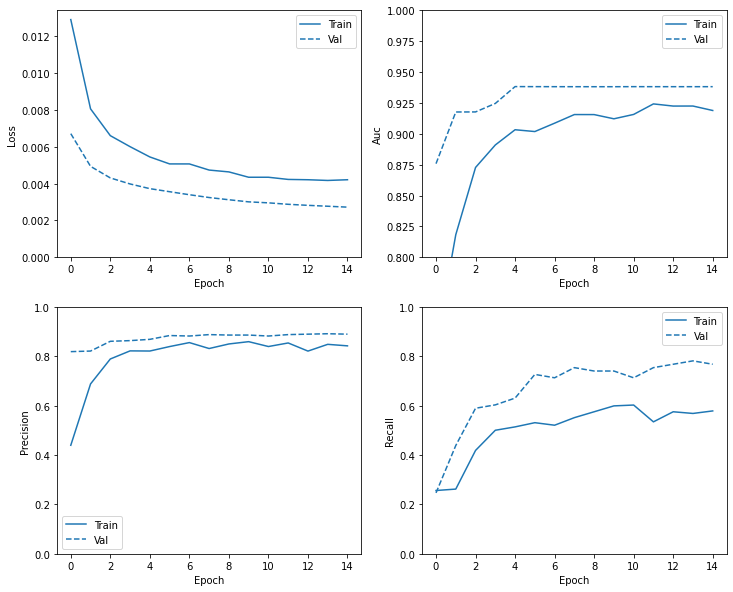

In [25]:
plot_metrics(baseline_history)

### evaluate metrics

In [26]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [27]:
# confusion matrix
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.004862332716584206
tp :  77.0
fp :  9.0
tn :  56828.0
fn :  48.0
accuracy :  0.9989993572235107
precision :  0.895348846912384
recall :  0.6159999966621399
auc :  0.9238050580024719

Legitimate Transactions Detected (True Negatives):  56828
Legitimate Transactions Incorrectly Detected (False Positives):  9
Fraudulent Transactions Missed (False Negatives):  48
Fraudulent Transactions Detected (True Positives):  77
Total Fraudulent Transactions:  125


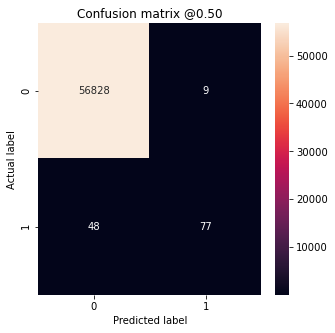

In [28]:
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

### ROC

In [29]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

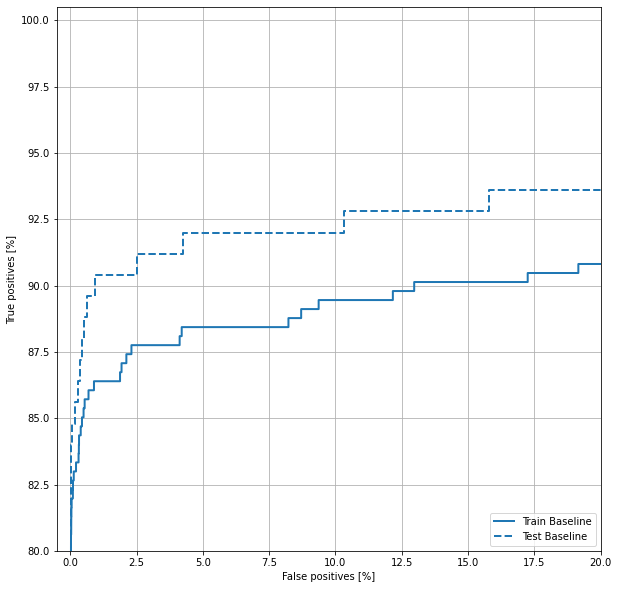

In [30]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

# Class weights

In [31]:
# scale the weights based on imbalanced class
weight_for_0 = (1 / neg) * total / 2.0
weight_for_1 = (1 / pos) * total / 2.0

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### train

In [32]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping], validation_data=(val_features, val_labels), class_weight=class_weights)

Epoch 1/100
90/90 [==============================] - 2s 17ms/step - loss: 2.2212 - tp: 147.0000 - fp: 481.0000 - tn: 238338.0000 - fn: 272.0000 - accuracy: 0.9969 - precision: 0.2341 - recall: 0.3508 - auc: 0.7706 - val_loss: 0.0097 - val_tp: 36.0000 - val_fp: 57.0000 - val_tn: 45439.0000 - val_fn: 37.0000 - val_accuracy: 0.9979 - val_precision: 0.3871 - val_recall: 0.4932 - val_auc: 0.9052
Epoch 2/100
90/90 [==============================] - 1s 7ms/step - loss: 1.0372 - tp: 150.0000 - fp: 707.0000 - tn: 181275.0000 - fn: 144.0000 - accuracy: 0.9953 - precision: 0.1750 - recall: 0.5102 - auc: 0.8785 - val_loss: 0.0130 - val_tp: 58.0000 - val_fp: 122.0000 - val_tn: 45374.0000 - val_fn: 15.0000 - val_accuracy: 0.9970 - val_precision: 0.3222 - val_recall: 0.7945 - val_auc: 0.9481
Epoch 3/100
90/90 [==============================] - 1s 7ms/step - loss: 0.7293 - tp: 188.0000 - fp: 967.0000 - tn: 181015.0000 - fn: 106.0000 - accuracy: 0.9941 - precision: 0.1628 - recall: 0.6395 - auc: 0.8953

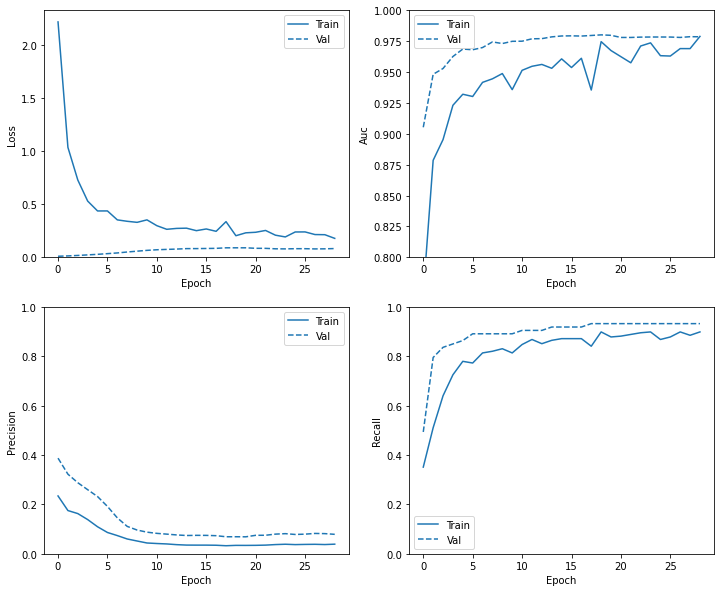

In [33]:
plot_metrics(weighted_history)

### evaluate

In [34]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.09192102402448654
tp :  115.0
fp :  1203.0
tn :  55634.0
fn :  10.0
accuracy :  0.978705108165741
precision :  0.08725341409444809
recall :  0.9200000166893005
auc :  0.9766051769256592

Legitimate Transactions Detected (True Negatives):  55634
Legitimate Transactions Incorrectly Detected (False Positives):  1203
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  115
Total Fraudulent Transactions:  125


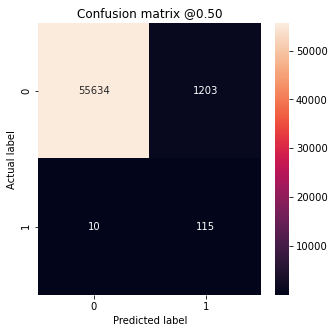

In [35]:
weighted_results = weighted_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

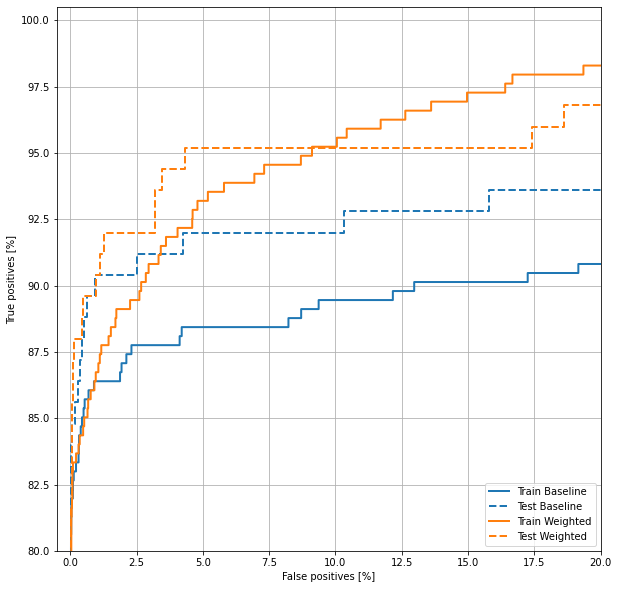

In [36]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')

# Oversampling

In [37]:
# an alternative approach to class weights is to oversample the minority class
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

### using numpy

In [38]:
# sample the positive samples to be same number as neg
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181982, 29)

In [39]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363964, 29)

### using tf.data

In [40]:
# balance the classes by creating a dataset for each, then merge them
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [41]:
# check dataset
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print('Label: ', label.numpy())

Features:
 [-0.34269586  0.56891434  0.40237777  1.86605449 -1.95859568  1.46649986
 -1.31239765 -4.41300404  0.1935762  -1.90935729 -0.51811079  1.00287626
 -0.08901586 -1.58320521 -0.49223802 -0.37477724  2.70974478  0.84712092
  1.12083302  1.89094354 -3.42184096  1.98003426  0.54650383  1.0713481
  1.10641939  0.15905906  0.86025476  0.87644809  1.40335744]

Label:  1


In [42]:
# merge dataset
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [43]:
# check dataset
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.5009765625


In [44]:
# get number of steps per epoch
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### train

In [45]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# reset bias to zero, since dataset is balanced
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(resampled_ds, epochs=EPOCHS, steps_per_epoch=resampled_steps_per_epoch, callbacks=[early_stopping], validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 6s 20ms/step - loss: 0.4515 - tp: 231322.0000 - fp: 65268.0000 - tn: 276089.0000 - fn: 53627.0000 - accuracy: 0.8102 - precision: 0.7799 - recall: 0.8118 - auc: 0.8883 - val_loss: 0.2038 - val_tp: 67.0000 - val_fp: 1072.0000 - val_tn: 44424.0000 - val_fn: 6.0000 - val_accuracy: 0.9763 - val_precision: 0.0588 - val_recall: 0.9178 - val_auc: 0.9654
Epoch 2/100
278/278 [==============================] - 5s 16ms/step - loss: 0.2031 - tp: 256430.0000 - fp: 16620.0000 - tn: 268493.0000 - fn: 27801.0000 - accuracy: 0.9220 - precision: 0.9391 - recall: 0.9022 - auc: 0.9726 - val_loss: 0.1131 - val_tp: 68.0000 - val_fp: 958.0000 - val_tn: 44538.0000 - val_fn: 5.0000 - val_accuracy: 0.9789 - val_precision: 0.0663 - val_recall: 0.9315 - val_auc: 0.9749
Epoch 3/100
278/278 [==============================] - 5s 16ms/step - loss: 0.1573 - tp: 262661.0000 - fp: 11567.0000 - tn: 272223.0000 - fn: 22893.0000 - accuracy: 0.9395 - precision: 0.9578 -

### check training

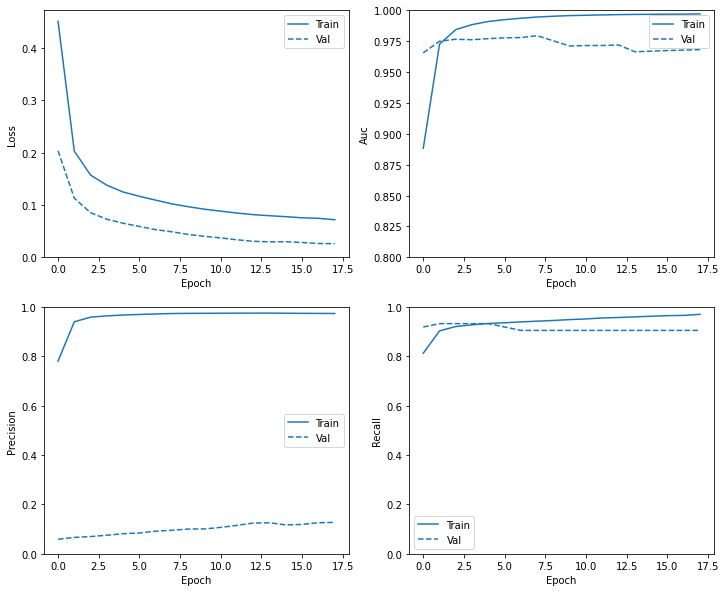

In [46]:
plot_metrics(resampled_history)

### re-train

In [47]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# reset bias to zero, since dataset is balanced
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(resampled_ds, steps_per_epoch=20, epochs=10*EPOCHS, callbacks=[early_stopping], validation_data=(val_ds))

uc: 0.9574 - val_loss: 0.2045 - val_tp: 68.0000 - val_fp: 1112.0000 - val_tn: 44384.0000 - val_fn: 5.0000 - val_accuracy: 0.9755 - val_precision: 0.0576 - val_recall: 0.9315 - val_auc: 0.9659
Epoch 15/1000
20/20 [==============================] - 0s 20ms/step - loss: 0.2407 - tp: 18342.0000 - fp: 1544.0000 - tn: 18797.0000 - fn: 2277.0000 - accuracy: 0.9067 - precision: 0.9224 - recall: 0.8896 - auc: 0.9597 - val_loss: 0.1922 - val_tp: 68.0000 - val_fp: 1102.0000 - val_tn: 44394.0000 - val_fn: 5.0000 - val_accuracy: 0.9757 - val_precision: 0.0581 - val_recall: 0.9315 - val_auc: 0.9672
Epoch 16/1000
20/20 [==============================] - 0s 21ms/step - loss: 0.2329 - tp: 18235.0000 - fp: 1547.0000 - tn: 18974.0000 - fn: 2204.0000 - accuracy: 0.9084 - precision: 0.9218 - recall: 0.8922 - auc: 0.9636 - val_loss: 0.1808 - val_tp: 68.0000 - val_fp: 1077.0000 - val_tn: 44419.0000 - val_fn: 5.0000 - val_accuracy: 0.9763 - val_precision: 0.0594 - val_recall: 0.9315 - val_auc: 0.9682
Epoch 17

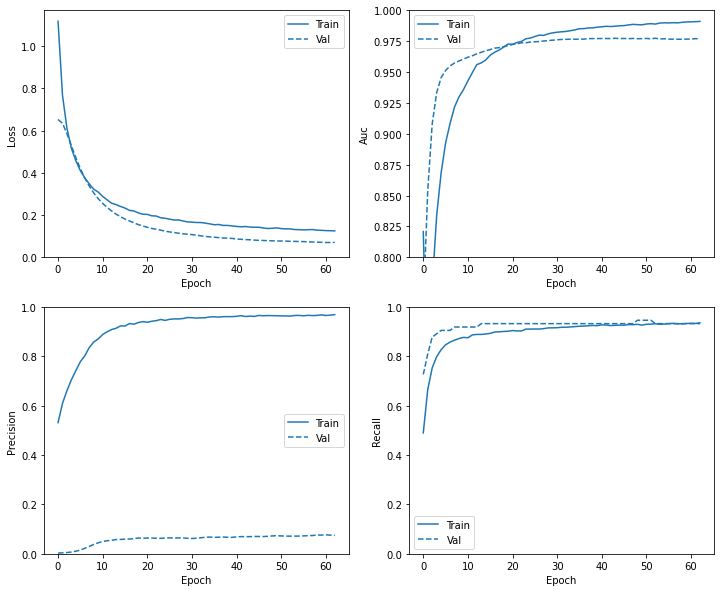

In [48]:
plot_metrics(resampled_history)

### evaluate

In [49]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.0767936110496521
tp :  115.0
fp :  1135.0
tn :  55702.0
fn :  10.0
accuracy :  0.9798988699913025
precision :  0.09200000017881393
recall :  0.9200000166893005
auc :  0.9798243641853333

Legitimate Transactions Detected (True Negatives):  55702
Legitimate Transactions Incorrectly Detected (False Positives):  1135
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  115
Total Fraudulent Transactions:  125


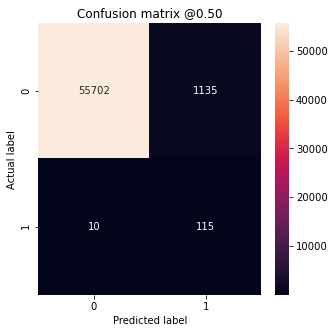

In [51]:
resampled_results = resampled_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()
plot_cm(test_labels, test_predictions_resampled)

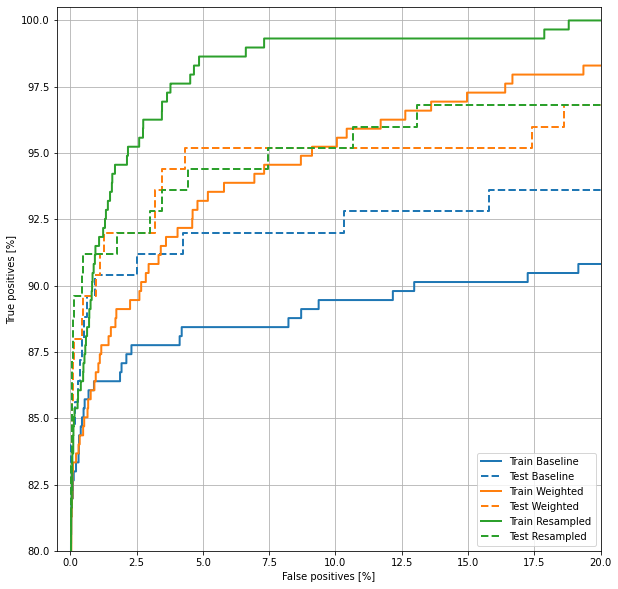

In [52]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')